In [ ]:
from google.colab import drive
drive.mount('/content/crive')

Mounted at /content/crive


In [2]:
# basic libraries 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


#statsmodels tools
import statsmodels.api as sm
from statsmodels.datasets import nile
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller, kpss, acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

In [125]:
#To implement the models, I am using the data to have a monthly sales value of alcohol for 1964 to 1972.
# Importing the data set.
alcohol =pd.read_csv('/content/crive/MyDrive/SARIMAX/data.csv')

In [126]:
alcohol.head()

,Month,Sales
0,1964-01,2815
1,1964-02,2672
2,1964-03,2755
3,1964-04,2721
4,1964-05,2946


In [127]:
type(alcohol)

pandas.core.frame.DataFrame

In [128]:
alcohol.tail()

,Month,Sales
100,1972-05,4618
101,1972-06,5312
102,1972-07,4298
103,1972-08,1413
104,1972-09,5877


In [129]:
alcohol.index = pd.to_datetime(alcohol['Month'])
alcohol.drop(columns='Month',inplace=True)
alcohol.head()

,Sales
Month,
1964-01-01,2815
1964-02-01,2672
1964-03-01,2755
1964-04-01,2721
1964-05-01,2946


In [130]:
alcohol.describe()

,Sales
count,105.000000
mean,4761.152381
std,2553.502601
min,1413.000000
25%,3113.000000
50%,4217.000000
75%,5221.000000
max,13916.000000


In [131]:
alcohol.isna().sum()

Sales    0
dtype: int64

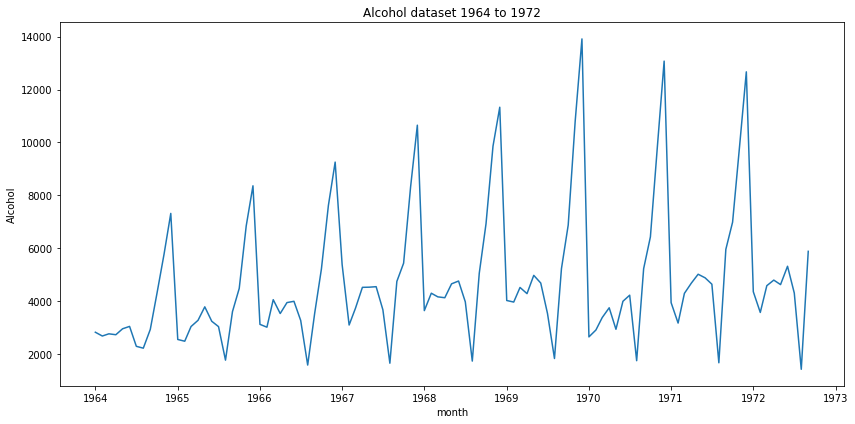

In [132]:
#plot
plt.figure(figsize=(12,6))
plt.plot(alcohol)
plt.xlabel('month')
plt.ylabel('Alcohol')
plt.title('Alcohol dataset 1964 to 1972')
plt.tight_layout()
plt.show()

Here, by the visualization only, we can see the availability of the seasonality in the data set. In the graph, we can see that the magnitude of the sales is changed repeatedly, showing the changes almost similar for different time intervals.

Four kinds of components help make a time series, and also they can affect our time series analysis if present in excess. So here, for this time series, we need to check more for the availability of components.

### Decomposing the time series.

In [133]:
# additive decompostion model
alcohol_result_add=seasonal_decompose(alcohol, model= "additive")

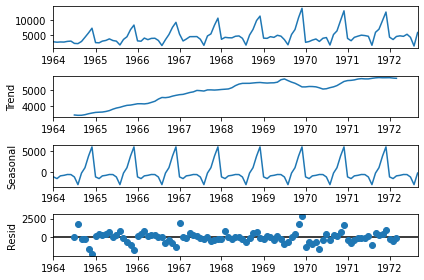

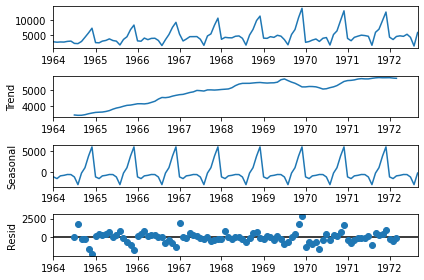

In [134]:
alcohol_result_add.plot()

In [135]:
# Multiplicativedecompostion model
alcohol_result_multi=seasonal_decompose(alcohol,model= "multiplicative")

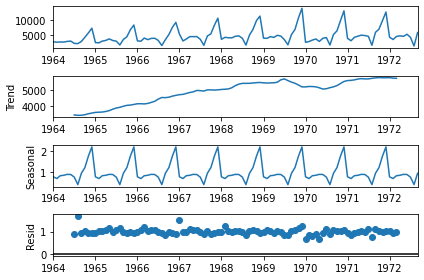

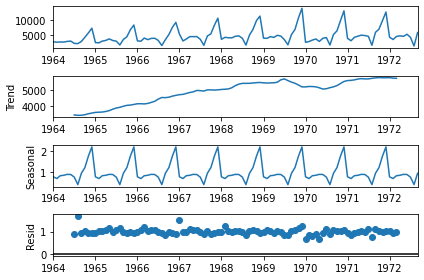

In [136]:
alcohol_result_multi.plot()

Here we can clearly see by visualization that there is trend and season is present in the time series also the residual is showing high variability.

Here we can see that the range of trend and residual is nominal, or we can say that trend is having variation between 4000 to 5000, and most of the time residual is having the variation around. But for the seasonality, we can see that it varies between 0 to 5000, which is a high difference range.

### We can also visualize the components separately.

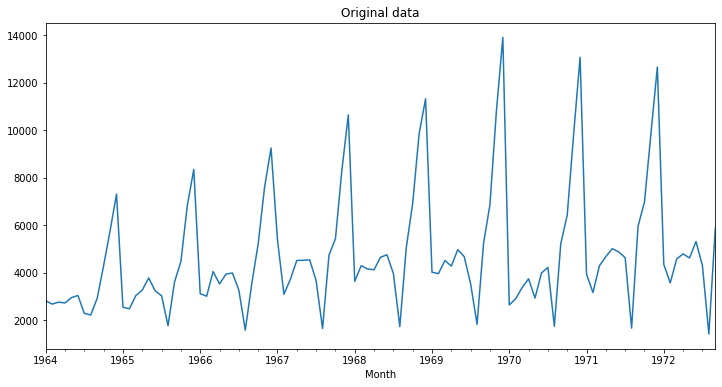

In [137]:
observed=alcohol_result_add.observed
plt.figure(figsize=(12,6))
observed.plot()
plt.title('Original data')
plt.show()

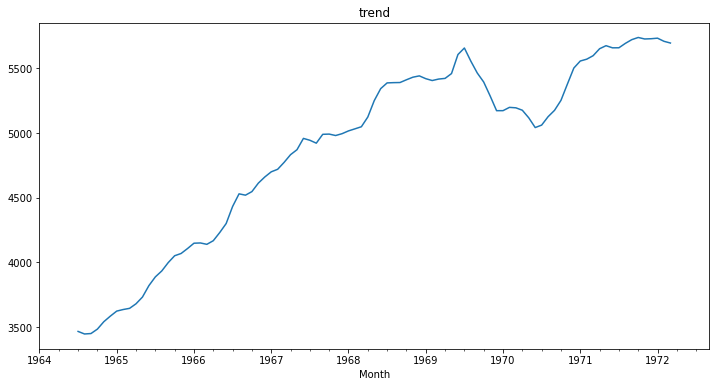

In [138]:
trend=alcohol_result_add.trend
plt.figure(figsize=(12,6))
trend.plot()
plt.title('trend')
plt.show()

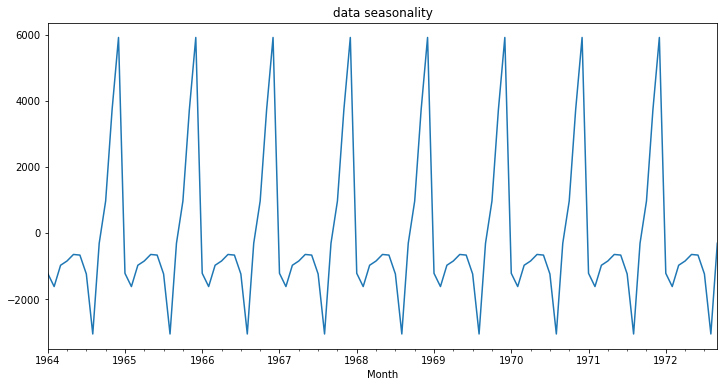

In [139]:
#Visualizing the tseasonality
seasonal=alcohol_result_add.seasonal
plt.figure(figsize=(12,6))
seasonal.plot()
plt.title('data seasonality')
plt.show()

I think now we can easily see the seasonality effect in our time series. In the above image, we have extracted the seasonality from the time series.

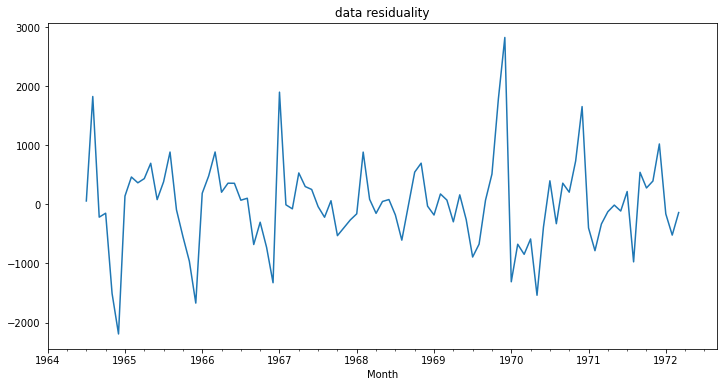

In [140]:
#Visualizing the resuality
residue=alcohol_result_add.resid
plt.figure(figsize=(12,6))
residue.plot()
plt.title('data residuality')
plt.show()

### Saving the components in tabular form by simply concatenating them

In [141]:
components=pd.concat([trend,seasonal, residue, observed], axis=1)
components.dropna(inplace=True)
components

,trend,seasonal,resid,0
Month,,,,
1964-07-01,3466.750000,-1242.500124,57.750124,2282.0
1964-08-01,3447.125000,-3060.505332,1825.380332,2212.0
1964-09-01,3450.416667,-312.390749,-216.025918,2922.0
1964-10-01,3484.625000,965.729043,-149.354043,4301.0
1964-11-01,3541.916667,3730.130084,-1508.046751,5764.0
...,...,...,...,...
1971-11-01,5725.833333,3730.130084,395.036582,9851.0
1971-12-01,5727.750000,5919.942584,1022.307416,12670.0
1972-01-01,5732.041667,-1223.411582,-160.630084,4348.0


### Checking stationarity

To perform forecasting using the ARIMA model, we required a stationary time series. Stationary time series is a time series that is unaffected by these four components. Most often, it happens when the data is non-stationary the predictions we get from the ARIMA model are worse or not that accurate.

If the data is not stationary, we can do one thing: either make the data stationary use ARIMA model or use the SARIMAX model.

To know more about the time series stationarity, we can perform the ADfuller test, a test based on hypothesis, where if the p-value is less than 0.05, then we can consider the time series is stationary, and if the P-value is greater than 0.05, then the time series is non-stationary.

In [142]:
#Performing the adfuller test on data.

adf=adfuller(alcohol)
adf

(-1.8335930563276188,
 0.363915771660247,
 11,
 93,
 {'1%': -3.502704609582561,
  '5%': -2.8931578098779522,
  '10%': -2.583636712914788},
 1478.4633060594724)

Here we can see that the p-value is higher for our dataset, and we can say that the evidence of the null hypothesis is low; hence the time series is non-stationary. We can make the time series stationary with differencing methods. In this case, we are going ahead with the rolling mean differencing methods.

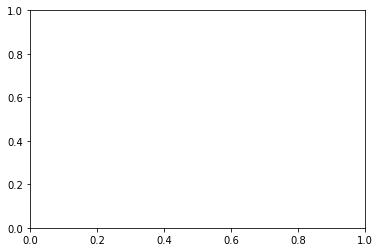

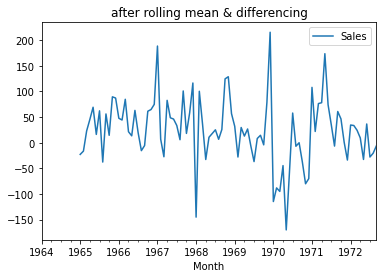

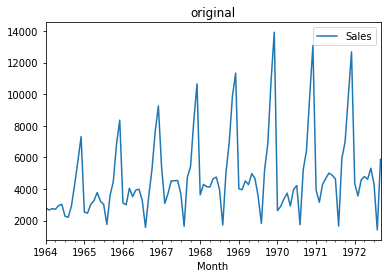

In [143]:
#Appling the rolling mean differencing
rolling_mean= alcohol.rolling(window = 12).mean()
rolling_mean_diff = rolling_mean - rolling_mean.shift()
ax1 = plt.subplot()
rolling_mean_diff.plot(title='after rolling mean & differencing');
ax2 = plt.subplot()
alcohol.plot(title='original'); 

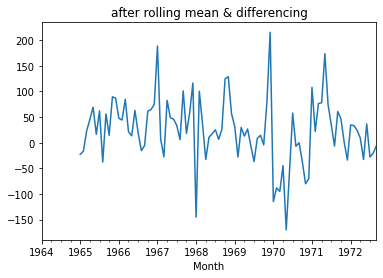

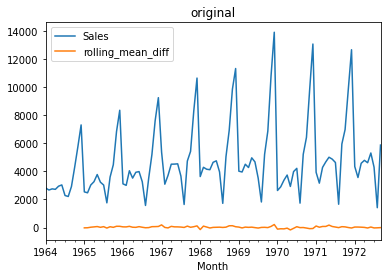

In [144]:
rolling_mean = alcohol.rolling(window = 12).mean()
alcohol['rolling_mean_diff'] = rolling_mean - rolling_mean.shift()
ax1 = plt.subplot()
alcohol['rolling_mean_diff'].plot(title='after rolling mean & differencing');
ax2 = plt.subplot()
alcohol.plot(title='original');

In [145]:
#check the p value
adfuller(rolling_mean_diff.dropna())

(-7.626619157213174,
 2.0605796968135582e-11,
 0,
 92,
 {'1%': -3.503514579651927,
  '5%': -2.893507960466837,
  '10%': -2.583823615311909},
 897.1902744899638)

We can see that the p-value is near about zero and very less than 0.05; now, our time series is stationary. So after these all processes, we can move to the modelling side.

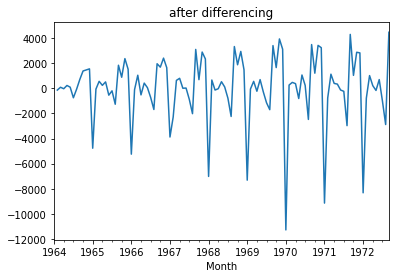

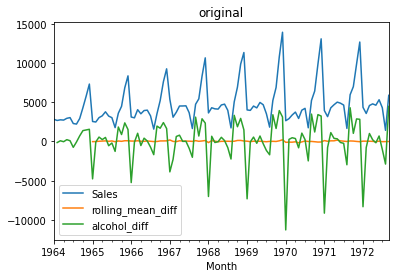

In [146]:
alcohol['alcohol_diff'] = alcohol['Sales'].diff()
ax1 = plt.subplot()
alcohol['alcohol_diff'].plot(title='after differencing');
ax2 = plt.subplot()
alcohol.plot(title='original');

In [147]:
 alcohol.dropna()

,Sales,rolling_mean_diff,alcohol_diff
Month,,,
1965-01-01,2541,-22.833333,-4771.0
1965-02-01,2475,-16.416667,-66.0
1965-03-01,3031,23.000000,556.0
1965-04-01,3266,45.416667,235.0
1965-05-01,3776,69.166667,510.0
...,...,...,...
1972-05-01,4618,-32.666667,-170.0
1972-06-01,5312,36.500000,694.0
1972-07-01,4298,-27.916667,-1014.0


### ARIMA
In statistics and in time series analysis, an  ARIMA( autoregressive integrated moving average) model is an update of ARMA (autoregressive moving average). The ARMA consists of mainly two components, the autoregressive and moving average; the ARIMA consists of an integrated moving average of autoregressive time series.  ARIMA model is useful in the cases where the time series is non-stationary. And the differencing is required to make the time series stationary. 



Our basic motive in this time series analysis is to use the ARIMA model to predict the future value and compare it with the SARIMAX model.

### compute p and q

### Implementation of the model without differencing.

In [148]:
model = ARIMA(alcohol['Sales'],order=(1,1,1))
history=model.fit()

In [149]:
history.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Sales   No. Observations:                  105
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -952.814
Date:                Thu, 01 Dec 2022   AIC                           1911.627
Time:                        19:05:00   BIC                           1919.560
Sample:                    01-01-1964   HQIC                          1914.841
                         - 09-01-1972                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4545      0.114      3.999      0.000       0.232       0.677
ma.L1         -0.9666      0.056    -17.316      0.000      -1.076      -0.857
sigma2      5.226e+06   6.17e+05      8.473      0.000    4.02e+06    6.43e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.91   Jarque-Bera (JB):                 2.59
Prob(Q):                              0.34   Prob(JB):                         0.27
Heteroskedasticity (H):               3.40   Skew:                             0.05
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

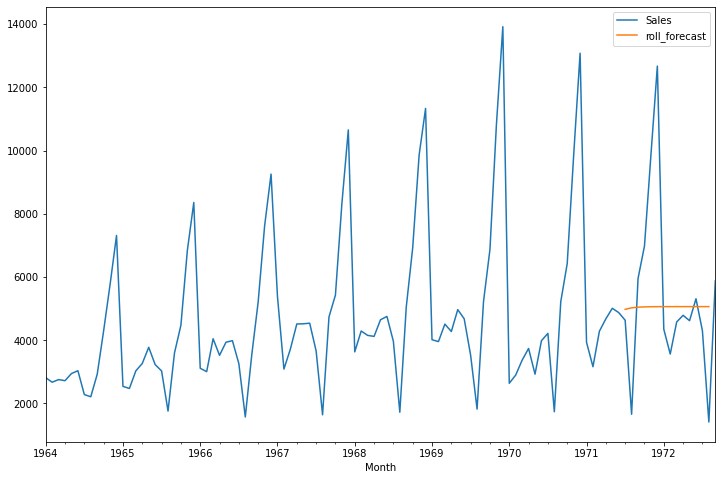

In [150]:
#Testing the fitted model.
alcohol['forecast']= history.predict(start=90,end=103,dynamic=True)
alcohol[['Sales','forecast']].plot(figsize=(12,8))

Here we can easily see the results we have got by the model is very unsatisfactory. This is because we have fit the model with a non-stationary time series. Without the stationary data, the model is not going to perform well. 

In [151]:
alcohol.dropna()

,Sales,rolling_mean_diff,alcohol_diff,roll_forecast
Month,,,,
1971-07-01,4633,34.666667,-241.0,4977.053686
1971-08-01,1659,-6.583333,-2974.0,5023.891122
1971-09-01,5951,60.833333,4292.0,5045.178526
1971-10-01,6981,46.416667,1030.0,5054.853555
1971-11-01,9851,0.750000,2870.0,5059.250812
1971-12-01,12670,-33.833333,2819.0,5061.249346
1972-01-01,4348,34.500000,-8322.0,5062.157670
1972-02-01,3564,33.500000,-784.0,5062.570500
1972-03-01,4577,24.250000,1013.0,5062.758129


Next, we are going to apply the model with the data after differencing the time series

In [152]:
#Fitting and training the model.
model=ARIMA(alcohol['rolling_mean_diff'].dropna(),order=(1,1,1))
model_fit=model.fit()

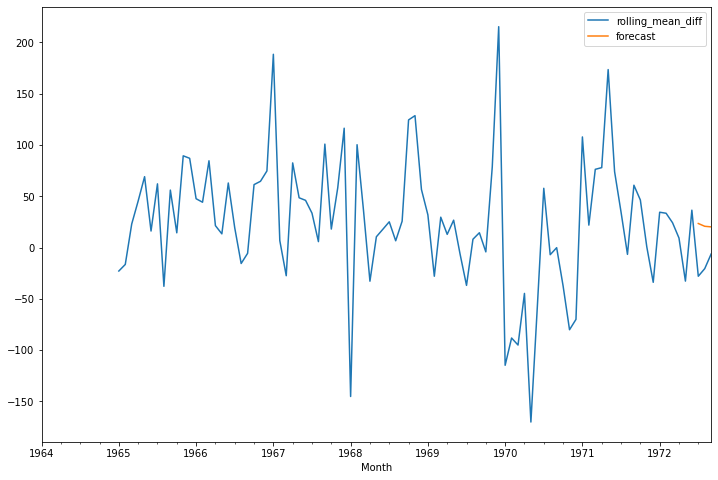

In [153]:
#Testing the fitted model.
alcohol['roll_forecast']=model_fit.predict(start=90,end=103,dynamic=True)
alcohol[['rolling_mean_diff','roll_forecast']].plot(figsize=(12,8))

Here we can see that our forecast is lying approximately on the given data in all processes we are trying to make predictions on available data and the values are quite satisfying but not the data we used after differencing, which means the values we are going to predict also without the seasonality effect or any other affecting components. So to get rid of the situation, we can use the SARIMAX model. So let’s have an overview of SARIMAX

In [154]:
#Fitting and training the model.
alcohol_diff_model=ARIMA(alcohol['alcohol_diff'].dropna(),order=(1,1,1))
model_al_diff=alcohol_diff_model.fit()

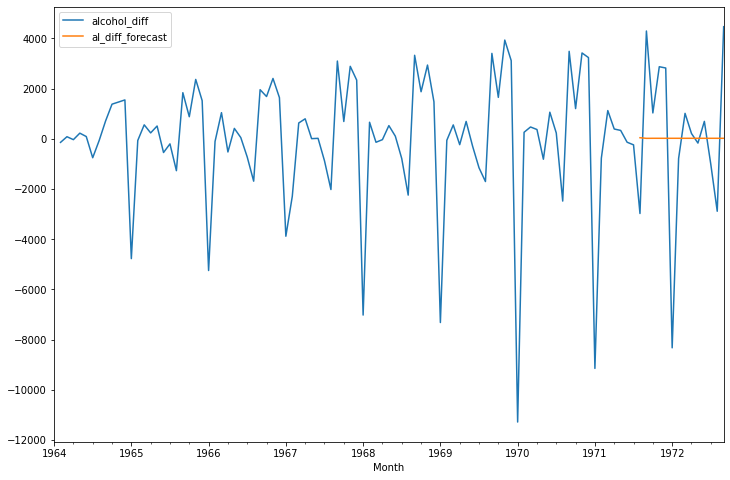

In [155]:
#Testing the fitted model.
alcohol['al_diff_forecast']=model_al_diff.predict(start=90,end=103,dynamic=True)
alcohol[['alcohol_diff','al_diff_forecast']].plot(figsize=(12,8))

### SARIMAX

SARIMAX(Seasonal Auto-Regressive Integrated Moving Average with eXogenous factors) is an updated version of the ARIMA model. ARIMA includes an autoregressive integrated moving average, while SARIMAX includes seasonal effects and eXogenous factors with the autoregressive and moving average component in the model. Therefore, we can say SARIMAX is a seasonal equivalent model like SARIMA and Auto ARIMA.

Another seasonal equivalent model holds the seasonal pattern; it can also deal with external effects. This feature of the model differs from other models. For example, in a time series, the temperature has seasonal effects like it is low in winter, high in summers. Still, with the effect of external factors like humidity, the temperature in winter is increased and also due to rain, there is a chance of lower temperature. We can’t predict the exact value for these factors if they do not appear in a cyclic or any seasonal behaviour. Other models are not capable of dealing with this kind of data.

In the SARIMAX models parameter, we need to provide two kinds of orders. The first one is similar to the ARIMAX model (p, d, q), and the other is to specify the effect of the seasonality; we call this order a seasonal order in which we are required to provide four numbers. 

(Seasonal AR specification, Seasonal Integration order, Seasonal MA, Seasonal periodicity)

In [156]:
#Fitting the model into time series.
model=sm.tsa.statespace.SARIMAX(alcohol['Sales'],order=(1, 1, 1),seasonal_order=(1,1,1,12))
results=model.fit()

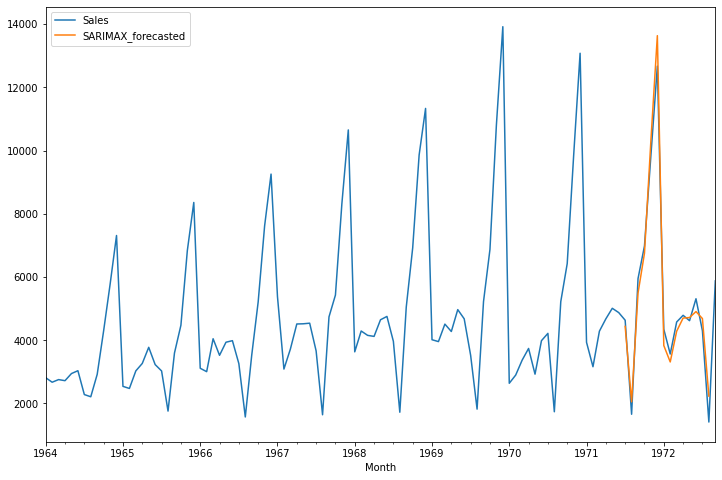

In [157]:
#Testing the fitted model.
alcohol['SARIMAX_forecasted']=results.predict(start=90,end=103,dynamic=True)
alcohol[['Sales','SARIMAX_forecasted']].plot(figsize=(12,8))

Here in the graph, we can see the results: the forecasting line is almost lying on the given values for this model. We didn’t even require the differencing method. Using this model now, we can predict the future values too. 

In [158]:
alcohol.dropna()

,Sales,rolling_mean_diff,alcohol_diff,roll_forecast,forecast,al_diff_forecast,SARIMAX_forecasted
Month,,,,,,,
1972-07-01,4298,-27.916667,-1014.0,5062.907785,23.502010,20.269889,4685.437992
1972-08-01,1413,-20.500000,-2885.0,5062.911423,20.787221,20.269889,2232.409287
